In [98]:
import numpy as np
import os
from skimage.measure import block_reduce
from scipy.misc import imread
import cPickle as pkl
import scipy.signal
import numpy.fft as fft
import sys
import optparse
from libtiff import TIFF
from PIL import Image
import re
import itertools
from scipy import ndimage

import math
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.cm as cm
import pandas as pd

%matplotlib inline


In [133]:
# outdir = '/media/juliana/TOSHIBA EXT/widefield/CE004/20160203/awake_circle_0013_REV/structs'
# outdir = '/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013_REV/structs'

outdir = '/media/nas/volume1/widefield/data/JR009/20150709/20150709_JR009_500um_05Hz_nored/structs' #V-Left ok
circle = False


reduceit = 0

if circle:
    CW = True #options.rev # CW IS REVERSE

    print "REV STATE: ", CW
    if rev=='False' and '_CW' in outdir:
        print "Fixing REV status [CW detected in fn]..."
        CW = True

    key = 'stimulus' #options.key
    
    rundir = os.path.split(outdir)[0]
    sessiondir = os.path.split(rundir)[0]
    
else:
    sessiondir = os.path.split(outdir)[0]
    

print sessiondir

/media/nas/volume1/widefield/data/JR009/20150709/20150709_JR009_500um_05Hz_nored


In [134]:
#################################################################################
# GET DATA STRUCT FILES:
#################################################################################

files = os.listdir(outdir)
files = [f for f in files if os.path.splitext(f)[1] == '.pkl']
dstructs = [f for f in files if 'Target_fft' in f]

print dstructs

D = dict()
for f in dstructs:
	outfile = os.path.join(outdir, f)
	with open(outfile,'rb') as fp:
		D[f] = pkl.load(fp)
print D.keys()


['Target_fft_V-Left_0_(2, 2)_nas.pkl', 'Target_fft_V-Right_0_(2, 2)_nas.pkl', 'Target_fft_H-Down_0_(2, 2)_nas.pkl']
['Target_fft_V-Left_0_(2, 2)_nas.pkl', 'Target_fft_H-Down_0_(2, 2)_nas.pkl', 'Target_fft_V-Right_0_(2, 2)_nas.pkl']


Choose key...
Current key:  Target_fft_H-Down_0_(2, 2)_nas.pkl
Curr DIR:  /media/nas/volume1/widefield/data/JR009/20150709/20150709_JR009_500um_05Hz_nored/structs


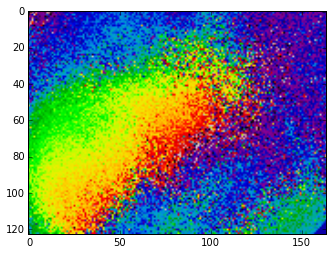

In [135]:
# Choose stimulus key:
if circle:
    if CW:
        cwkey = D.keys()[0]
        cwmap = D[cwkey]['ft']
        
    else:
        ccwkey = D.keys()[0]
        ccwmap = D[ccwkey]['ft']

else:
    print "Choose key..."

    run_num = '0'
    reduce_factor = (2, 2)
    append = 'nas'
    cond_type = 'Down'

    run_conds = [cond_type, str(run_num)+'_', str(reduce_factor), append]
    tmp_keys = [k for k in D.keys() if all([c in k for c in run_conds])] #[0]
    if len(tmp_keys) > 1:
        print "More than 1 match found: "
        print tmp_keys
    elif tmp_keys == []:
        print "No matches found from list: "
        print D.keys()
    else:
        if cond_type=='Left':
            leftkey = tmp_keys[0]
        elif cond_type=='Right':
            rightkey = tmp_keys[0]
        elif cond_type=='Down' or cond_type=='Top':
            topkey = tmp_keys[0]
        elif cond_type=='Up' or cond_type=='Bottom':
            bottomkey = tmp_keys[0]          
        

currkey = topkey
currmap = D[currkey]['ft']


reduce_factor = (2, 2)
if reduce_factor[0] > 0:
	reduceit=1
else:
	reduceit=0
    
print "Current key: ", currkey
plt.imshow(np.angle(currmap), cmap='spectral')
print "Curr DIR: ", outdir

In [136]:
# ft = np.empty(D[cw_key]['mean_intensity'].shape)
# ft = ft + 0j

# for x in range(ft.shape[0]):
#     for y in range(ft.shape[1]):
#         ft[x, y] = complex(D[cw_key]['ft_real'][x][y], D[cw_key]['ft_imag'][x][y])

# D[cw_key]['ft'] = ft


/media/nas/volume1/widefield/data/JR009/20150709/20150709_JR009_500um_05Hz_nored
['20150709_JR009_750um_below_coverslip_GREEN_Screen Shot 2015-07-09 at 4.58.58 PM.png']
.png


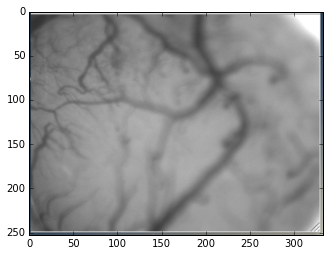

In [151]:
#################################################################################
# GET BLOOD VESSEL IMAGE:
#################################################################################

print sessiondir
folders = os.listdir(sessiondir)
figpath = [f for f in folders if f == 'figures']


if figpath:
    figdir = figpath[0]
    tmp_ims = os.listdir(os.path.join(sessiondir, figdir))
    surface_words = ['surface', 'GREEN', 'green', 'Surface']
    ims = [i for i in tmp_ims if any([word in i for word in surface_words])]
    print ims
    impath = os.path.join(sessiondir, figdir, ims[0])
    # image = Image.open(impath) #.convert('L')
    # imarray = np.asarray(image)
    print os.path.splitext(impath)[1]
    if os.path.splitext(impath)[1] == '.tif':
        tiff = TIFF.open(impath, mode='r')
        imarray = tiff.read_image().astype('float')
        tiff.close()
        plt.imshow(imarray)
    else:
        image = Image.open(impath) #.convert('L')
        imarray = np.asarray(image)


else: # NO BLOOD VESSEL IMAGE...
    imarray = np.zeros([200,300])

reduceit = 0
if reduceit:
    imarray = block_reduce(imarray, reduce_factor, func=np.mean)

plt.imshow(imarray, cmap='gray')

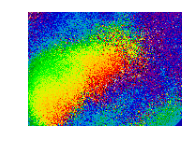

In [152]:
fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(np.angle(currmap), cmap='spectral')
plt.axis('off')

if circle:
    ax = fig.add_subplot(1,2,2, projection='polar')
    ax.set_theta_zero_location('W') # W puts 0 on RIGHT side...

    ax._direction = 2*np.pi # object moves toward bottom first (CW)

    # ax._direction = -2*np.pi # objecct moves toward top first (CCW)

    norm = mpl.colors.Normalize(vmax=1*np.pi, vmin=-1*np.pi)
    #norm = mpl.colors.Normalize(vmax=2*np.pi, vmin=0)
    cb = mpl.colorbar.ColorbarBase(ax, cmap=cm.get_cmap('spectral'),
                                    norm=norm, orientation='horizontal')
    # cb.ax.invert_xaxis()
    # cb.outline.set_visible(False)
    # ax.set_axis_off()
    ax.set_rlim([-1, 1])
    ax.axis('off')



<matplotlib.colorbar.Colorbar instance at 0x7effb7b47878>

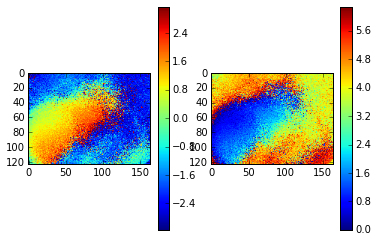

In [144]:

plt.subplot(1,2,1)
phase_map = np.angle(currmap)
plt.imshow(phase_map)
plt.colorbar()


plt.subplot(1,2,2)
shifted_phase_map = np.angle(currmap)
for x in range(shifted_phase_map.shape[0]):
    for y in range(shifted_phase_map.shape[1]):
        if shifted_phase_map[x,y] < 0:
            shifted_phase_map[x,y] += 2*math.pi
plt.imshow(shifted_phase_map)
plt.colorbar()


<matplotlib.colorbar.Colorbar instance at 0x7effb79c2ea8>

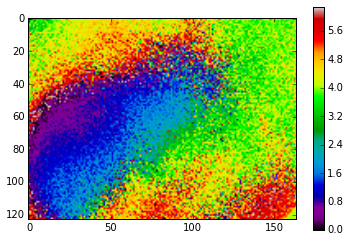

In [145]:
p = shifted_phase_map
plt.imshow(p, cmap='spectral')
plt.colorbar()

123


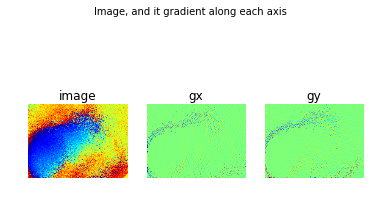

In [146]:
# p = np.flipud(shifted_phase_map)
p = shifted_phase_map

# plt.imshow(p)
gy, gx = np.gradient(p)
print len(gy)
# print "gx =", gx
# print "gy =", gy

# plotting
plt.close("all")
plt.figure()
plt.suptitle("Image, and it gradient along each axis")
ax = plt.subplot("131")
ax.axis("off")
ax.imshow(p)
ax.set_title("image")

ax = plt.subplot("132")
ax.axis("off")
ax.imshow(gx)
ax.set_title("gx")

ax = plt.subplot("133")
ax.axis("off")
ax.imshow(gy)
ax.set_title("gy")
plt.show()


/media/nas/volume1/widefield/data/JR009/20150709/20150709_JR009_500um_05Hz_nored/figures/phase_gradient_Target_fft_H-Down_0_(2, 2)_nas.pkl.jpg


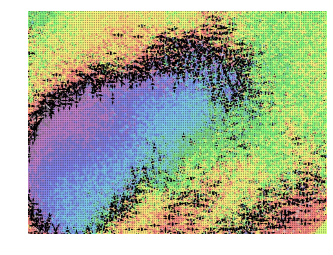

In [149]:
from pylab import *

# plt.subplot(1,2,1)
plt.imshow(p, cmap='spectral', alpha=0.5)

# plt.subplot(1,2,1)
Q = quiver(gx, gy)

# plt.subplot(1,2,2)
# Q = quiver(gx, gy)


# l,r,b,t = axis()
# dx, dy = r-l, t-b
# axis([l-0.05*dx, r+0.05*dx, b-0.05*dy, t+0.05*dy])

plt.axis('off')

# plt.colorbar()

figpath = os.path.join(os.path.split(outdir)[0], 'figures', 'phase_gradient_%s.jpg' % currkey)
plt.savefig(figpath)
print figpath

In [70]:
import plotly.plotly as py
from plotly.tools import FigureFactory as FF
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.offline import plot

# x, y = np.meshgrid(np.linspace(0, len(gx), len(gx)), np.linspace(0, len(gy), len(gy)))
x,y = np.meshgrid(np.arange(0, p.shape[0], 1), np.arange(0, p.shape[1], 1))
z = p[x, y] ##x * np.exp(-x**2 - y**2)

v, u = np.gradient(z, 1, 1) # .2, .2)

# x,y = np.meshgrid(np.arange(0, p.shape[0], 1), np.arange(0, p.shape[1], 1))
# x = range(p.shape[0])
# y = range(p.shape[0])

# u = gx #np.cos(x)*y
# v = gy #np.sin(x)*y

# v, u = np.gradient(p)

print len(y), len(v)

# Create quiver
# fig = FF.create_quiver(x, y, u, v)

# # Create quiver figure
# fig = FF.create_quiver(x, y, u, v,
#                        scale=.25,
#                        arrow_scale=.4,
#                        name='quiver',
#                        line=dict(width=1))


# plot(fig, filename='quiver plot')


109 109


In [60]:
# Create quiver figure
fig = FF.create_quiver(y, x, u, v)
#                        scale=.25,
#                        arrow_scale=.4,
#                        name='quiver',
#                        line=dict(width=1))


plot(fig, filename='quiver plot')

'file:///home/juliana/Repositories/retinotopy-mapper/quiver plot.html'

<matplotlib.colorbar.Colorbar instance at 0x7effbd1004d0>

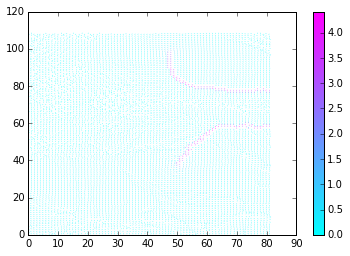

In [59]:
length  = np.sqrt(u**2 + v**2)
 
un = u/length
vn = v/length
 
plt.figure()
plt.quiver(x, y, un, vn,
          length,
          cmap = plt.cm.spectral,
          headlength = 20)
plt.colorbar()
# plt.axis([-1, 7, -1, 7])
# plt.title("scales with x view; pivot='tip'")

In [ ]:
import plotly.graph_objs as go

data = [
    go.Heatmap(
        
        z=shifted_phase_map
    )
]

plot_url = plot(data, filename='heatmap-test')


# plot(fig, filename='quiver plot')